# Linear Programming for Macro Capacity Planning with PuLP

This notebook demonstrates how to use the PuLP package for production network optimization and capacity planning. More information on PuLP can be found at https://pythonhosted.org/PuLP/ 

There are two general types of network optimization:

* Short-term/Tactical/Micro: on a daily/weekly horizon, how should we produce and ship based on demand forecasts and current inventory levels?
* Long-term/Strategic/Macro: on a 1-10 year horizon, how should we invest our resources and capital to get the best return on investment and support our business's stragic goals (e.g., market share)?

Questions that the stategic/macro network planner needs to answer:

* How unoptimized is our current supply chain/logistics network?
* What would demand growth need to be to justify building a new factory vs. co-manufacturing?
* Where should we build a new factory/warehouse?
* Which factory should we consider shutting down?
* Where should we produce the new product we want to launch?

In [1]:
from graphviz import Digraph
import pulp
import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
from IPython.display import display
import itertools
from geopy.distance import great_circle
from typing import NamedTuple
import random
import numpy
import math

## Simplifying Assumptions

For the purpose of this notebook, we'll make a number of simplifying assumptions. Some of these assumptions are actually reasonable to make in practice, depending on what decisions the optimization is meant to support.

* Selling only a single product
* No production minimums. Co-manufacturer contracts typically include minimum volume requirement
* Don't care about fixed costs, e.g., factory fixed overhead such as building maintenance
* Only a single production line at each factory
* Product must be transfered through a warehouse
* Single warehouse stop between factory and customer
* Warehouses can handle unlimited volume
* Assume no warehouse handling fees
* Ignore time and related effects, e.g., inventory, demand seasonality, etc.
* Transport cost rate is constant, e.g., assume always using full trucks 

# Defining a Production Network

Taking the above assumptions, we'll create a class to capture the physical structure of the supply chain network:

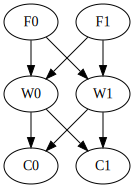

In [2]:
class Location(NamedTuple):
    lat: float
    lng: float

def random_location():
    """Return random lat/lng in the USA."""
    lat = random.uniform(24.7433195, 49.3457868)
    lng = random.uniform(-124.7844079, -66.9513812)
    return Location(lat=lat, lng=lng)
    
class RandomNetwork:
    """Create 1-layer fully-connected production network with a single product."""
        
    def __init__(self, num_factories, num_warehouses, num_customers):
        random.seed(42)        
        self.factories = [f'F{x}' for x in range(num_factories)]
        self.warehouses = [f'W{x}' for x in range(num_warehouses)]
        self.customers = [f'C{x}' for x in range(num_customers)]
        self.locations = {x: random_location() for x in self.factories + self.warehouses + self.customers}
    
    def distance(self, x, y):
        return great_circle(self.locations[x], self.locations[y]).miles
        
    def paths(self):
        return itertools.product(self.factories, self.warehouses, self.customers)

    def segments(self):
        return itertools.chain(
            itertools.product(self.factories, self.warehouses), 
            itertools.product(self.warehouses, self.customers),
        )
    
    def graph(self):
        dot = Digraph()
        for f, w in itertools.product(self.factories, self.warehouses):
            dot.edge(f, w)
        for w, c in itertools.product(self.warehouses, self.customers):
            dot.edge(w, c)
        return dot
       
network = RandomNetwork(2, 2, 2)
network.graph()


## Idea #1: Optimize over all paths

As a first attempt, we'll try encoding all feasible paths from a factory to a customer.

### Notation

* $F$: set of factories
* $W$: set of warehouses
* $C$: set of customers
* $\text{demand}(c)$: demand forecast (in units) for customer $c$
* $\text{capacity}(f)$: maximum capacity (in units) for factory $f$
* $\text{volume}(f, w, c)$: volume in units shipped sold at customer $c$ via factory $f$ and warehouse $w$
* $\text{price}(c)$: the price (dollars per unit), when unit at customer $c$
* $\text{production}(f)$: the production cost (dollars per unit), when producing at factory $f$
* $\text{transport}(f, w, c)$: transport cost (dollars per unit) of shipping to customer $c$ from factory $f$ via warehouse $w$


### Optimization problem

We'll have the optimizer try to compute a volume for each path: $volume(f, w, c)$

_Maximize Total Profit:_

$$\sum_{f \in F} \sum_{w \in W} \sum_{c \in C} [\text{price}(c) - \text{production}(f) - \text{transport}(f, w, c)] \cdot \text{volume}(f, w, c)$$

_Subject to:_

* Production constraint for each factory $f \in F$ $$\sum_{w \in W} \sum_{c \in C} \text{volume}(f, w, c) \leq \text{capacity}(f)$$
* Demand constraint for each customer $c \in C$ $$\sum_{f \in F} \sum_{w \in W} \text{volume}(f, w, c) \leq \text{demand}(c)$$


### Define Demand Set

A demand set is a volume and price scenario. It's good to decouple the demand forecast from the network configuration and cost so that it's possible to see how the production network will behave across multiple demand scenarios.

In [3]:
class RandomDemandSet:
    def __init__(self, network):
        random.seed(42)
        self.network = network
        self.price_lu = {x: max(random.normalvariate(3, 0.15), 2.0) for x in network.customers}
        self.demand_lu = {x: max(round(random.normalvariate(1000, 100)), 0.0) for x in network.customers}
    
    def demand(self, customer):
        """Demand forecast in units for customer."""
        return self.demand_lu[customer]
    
    def price(self, customer):
        """Price in $/unit received for selling product at a customer."""
        return self.price_lu[customer]


### Define Production/Transportation Cost Set

It's also beneficial to decouple the production/transportation cost set. This allows use to easily run multiple cost scenarios for a network. This is especially important in modelling external factors such as inflation and supply shocks.


In [4]:
class RandomCostSet:    
    def __init__(self, network):
        random.seed(42)
        self.network = network
        self.transport_unit_mile = max(random.normalvariate(0.00008, 0.000015), 0.00001)
        self.cost_lu = {x: max(random.normalvariate(0.75, 0.15), 0.25) for x in network.factories}
        self.capacity_lu = {x: max(round(random.normalvariate(1000, 100)), 0.0) for x in network.factories}
        
    def production_cost(self, factory):
        """Cost in $/unit for producing product at a factory."""
        return self.cost_lu[factory]

    def capacity(self, factory):
        """Production maximum capacity in units at factory."""
        return self.capacity_lu[factory]

    def transport_segment(self, source, destination):
        """Transport cost per unit for a path segment."""
        return self.network.distance(source, destination) * self.transport_unit_mile

    def transport_path(self, factory, warehouse, customer):
        """Total transport cost per unit for path."""
        return self.transport_segment(factory, warehouse) + self.transport_segment(warehouse, customer)

### Create the Routing Problem in PuLP

Here we create the routing problem. We create a wrapper for the raw PuLP optimization problem so we can easily access calculated constants and optimized values in analytics.

In [5]:
class PathProblemWrapper():
    def __init__(self, network, demand, cost):
        self.network = network
        self.demand = demand
        self.cost = cost
        self._create_problem()
        
    def volume_key(self, factory, warehouse, customer):
        """Return a string key for a path"""
        return f'{factory}:{warehouse}:{customer}'
        
    def get_var(self, factory, warehouse, customer):
        """Return the volume variable for a path"""
        return self.flow_vars[self.volume_key(factory, warehouse, customer)]

    def marginal_profit(self, factory, warehouse, customer):
        """Return profit per unit for a path."""
        price = self.demand.price(customer)
        production = self.cost.production_cost(factory)
        transport = self.cost.transport_path(factory, warehouse, customer)
        return price - production - transport

    def optimized_value(self, factory, warehouse, customer):
        """Return optimized flow value."""
        # optimized variable dict is keyed off of name
        var_name = self.get_var(factory, warehouse, customer).name
        return self.prob.variablesDict()[var_name].varValue
   
    def _create_problem(self):
        """Instantiate and return a PuLP optimization problem for routing over paths."""
        prob = pulp.LpProblem(f'Path Routing', pulp.LpMaximize)
        network = self.network
        
        # define variables to optimize over
        self.flow_vars = pulp.LpVariable.dicts(
            'Flows', 
            [self.volume_key(f, w, c) for f, w, c in network.paths()],
            lowBound=0
        )
 
        # define the expression to maximize
        flow_profit = [
            self.marginal_profit(f, w, c) * self.get_var(f, w, c)
            for f, w, c in network.paths()
        ]
        prob += pulp.lpSum(flow_profit), 'Total Profit'

        # define the factory capacity constraints
        for factory in network.factories:
            factory_volumes = [
                self.get_var(factory, w, c) 
                for w, c in itertools.product(network.warehouses, network.customers)
            ]
            prob += pulp.lpSum(factory_volumes) <= cost.capacity(factory), f'Factory {factory} Capacity'

        # define the customer demand constraints
        for customer in network.customers:
            customer_volumes = [
                self.get_var(f, w, customer) 
                for f, w in itertools.product(network.factories, network.warehouses)
            ]
            prob += pulp.lpSum(customer_volumes) <= demand.demand(customer), f'Customer {customer} Demand'

        self.prob = prob

In [6]:
demand = RandomDemandSet(network)
cost = RandomCostSet(network)

wrapper = PathProblemWrapper(network, demand, cost)
pulp_problem = wrapper.prob
pulp_problem


Path Routing:
MAXIMIZE
2.0268923505900456*Flows_F0:W0:C0 + 2.001267959558294*Flows_F0:W0:C1 + 2.2539648460010877*Flows_F0:W1:C0 + 2.066535324075787*Flows_F0:W1:C1 + 1.7894846779210776*Flows_F1:W0:C0 + 1.7638602868893263*Flows_F1:W0:C1 + 1.935645014670366*Flows_F1:W1:C0 + 1.7482154927450657*Flows_F1:W1:C1 + 0.0
SUBJECT TO
Factory_F0_Capacity: Flows_F0:W0:C0 + Flows_F0:W0:C1 + Flows_F0:W1:C0
 + Flows_F0:W1:C1 <= 986

Factory_F1_Capacity: Flows_F1:W0:C0 + Flows_F1:W0:C1 + Flows_F1:W1:C0
 + Flows_F1:W1:C1 <= 902

Customer_C0_Demand: Flows_F0:W0:C0 + Flows_F0:W1:C0 + Flows_F1:W0:C0
 + Flows_F1:W1:C0 <= 1125

Customer_C1_Demand: Flows_F0:W0:C1 + Flows_F0:W1:C1 + Flows_F1:W0:C1
 + Flows_F1:W1:C1 <= 986

VARIABLES
Flows_F0:W0:C0 Continuous
Flows_F0:W0:C1 Continuous
Flows_F0:W1:C0 Continuous
Flows_F0:W1:C1 Continuous
Flows_F1:W0:C0 Continuous
Flows_F1:W0:C1 Continuous
Flows_F1:W1:C0 Continuous
Flows_F1:W1:C1 Continuous

### Accessing Optimization Results

After attempting solving the problem, PuLP sets a status for whether the optimization succeeded, the constraints were infeasible, or another problem occurred. If the optimization succeeded, the optimal values are stored in the problems ``variablesDict``.

In [7]:
pulp_problem.solve()

print(f'Status? {pulp.LpStatus[pulp_problem.status]}')
print(f'Total Profit: {pulp.value(pulp_problem.objective)}')

for variable, value in pulp_problem.variablesDict().items():
    print(f'{variable}: {value.varValue}')


Status? Optimal
Total Profit: 3837.289394092809
Flows_F0:W0:C0: 0.0
Flows_F0:W0:C1: 0.0
Flows_F0:W1:C0: 986.0
Flows_F0:W1:C1: 0.0
Flows_F1:W0:C0: 0.0
Flows_F1:W0:C1: 763.0
Flows_F1:W1:C0: 139.0
Flows_F1:W1:C1: 0.0


### Summarizing Results

When analyzing the output of an optimizer, you should leverage the same kind of descriptive and diagnostic analytics you use for historic/current data.

Since we've optimized over paths, summarizing results is easy since we have all the complete end-to-end flows. To summarize for a given location (e.g., factory), we just need to aggregate over all the paths going through it.

In [8]:
def production_gap(wrapper):
    """Return optimal volume for each factory."""
    def city_volume(c):
        return sum([
            wrapper.optimized_value(f, w, c) 
            for f, w in itertools.product(network.factories, network.warehouses)
        ])
    
    return {
        c: wrapper.demand.demand(c) - city_volume(c)
        for c in network.customers
    }

def factory_utilization(wrapper):
    """Return optimal volume for each factory."""
    def factory_volume(f):
        return sum([
            wrapper.optimized_value(f, w, c) 
            for w, c in itertools.product(network.warehouses, network.customers)
        ])
    
    return {
        f:  factory_volume(f) / wrapper.cost.capacity(f) * 100.0
        for f in network.factories
    }

def factory_marginal_profit(wrapper):
    """Return optimal volume-weighted profit per unit for each factory."""
    result = {}
    wrapper.prob.solve()
    network = wrapper.network
    for factory in network.factories:
        volumes = [
            wrapper.optimized_value(factory, w, c)
            for w, c in itertools.product(network.warehouses, network.customers)
        ]
        profit = [
            wrapper.marginal_profit(factory, w, c)
            for w, c in itertools.product(network.warehouses, network.customers)
        ]        
        result[factory] = numpy.average(profit, weights=volumes) if sum(volumes) > 0 else None
    return result
   
wrapper.prob.solve()
print(f'Customer Production Gap (units): {production_gap(wrapper)}')
print(f'Factory Utilization (%): {factory_utilization(wrapper)}')
print(f'Factory Profit ($/unit): {factory_marginal_profit(wrapper)}')

Customer Production Gap (units): {'C0': 0.0, 'C1': 223.0}
Factory Utilization (%): {'F0': 100.0, 'F1': 100.0}
Factory Profit ($/unit): {'F0': 2.2539648460010877, 'F1': 1.7903326562480453}


In our case, factory F0 is on average more profitable, but doesn't have enough capacity to service all of the demand. Therefore, factory F1 is used to support F0 for customer C0 even though it's less profitable

## Problem: Optimization Problem Size

If we assume a single warehouse stop between the factory and customer, the number of variables we're optimizing over is:

* Complete Paths: $|F||W||C|$

However, what if we were to take advantage of the fact that where a warehouse ships is independent of where its received the product? How would the problem size change if we optimized over segments &mdash; from factory to warehouse and warehouse to customer?

* Path segments: $|F||W| + |W||C|$

How much benefit do we get by optimizing over path segments instead of paths?

In [9]:
def f(num_factory, num_warehouse, num_customer):
    path = num_factory * num_warehouse * num_customer
    segment = num_factory * num_warehouse + num_warehouse * num_customer
    display(path)
    display(segment)
    return f'{round(path / segment, 1)}x larger'

interact(
    f, 
    num_factory=IntSlider(min=1, max=50, step=1, value=5), 
    num_warehouse=IntSlider(min=1, max=50, step=1, value=4), 
    num_customer=IntSlider(min=1, max=4000, step=1, value=100)
)

interactive(children=(IntSlider(value=5, description='num_factory', max=50, min=1), IntSlider(value=4, descrip…

<function __main__.f(num_factory, num_warehouse, num_customer)>

So, depending on the number of factories/warehouses we have, we can make the optimization problem significantly smaller by optimizing over segments.

What about if we need to consider shipping products through more than one warehouse? The size of the optimization problem then becomes:

* Complete paths: $$|F| \cdot \sum_{k \leq |W|}\frac{|W|!}{(|W| - k)!} \cdot |C|$$
* Path segments: $$|F||W| + |W|^2 + |W||C|$$

Now, in reality, we could exclude paths that were obviously inefficient, e.g., paths that include shipping back and forth across the country. However, on real problems the size would still too big to solve in real time.

In [10]:
def num_perm(n, k):
    return math.factorial(n) / math.factorial(n - k)

def f(num_factory, num_warehouse, num_customer):
    path = num_factory * num_customer * sum([num_perm(num_warehouse, k) for k in range(num_warehouse + 1)])
    segment = num_factory * num_warehouse + num_warehouse * num_warehouse + num_warehouse * num_customer
    display(path)
    display(segment)
    return f'{round(path / segment, 1)}x larger'

interact(
    f, 
    num_factory=IntSlider(min=1, max=50, step=1, value=5), 
    num_warehouse=IntSlider(min=1, max=50, step=1, value=4), 
    num_customer=IntSlider(min=1, max=4000, step=1, value=100)
)

interactive(children=(IntSlider(value=5, description='num_factory', max=50, min=1), IntSlider(value=4, descrip…

<function __main__.f(num_factory, num_warehouse, num_customer)>

## Idea #2: Optimize over path segments

### Additional Notation

* Set of logistic network locations: $N = F \cup W \cup C$
* We'll define our price function to only generate revenue at a customer: $\text{price}(n) = 0$ if $n \notin C$
* We'll define our production cost function to only incur costs at a factory: $\text{production}(n) = 0$ if $n \notin F$

### Optimization Problem

We'll have the optimizer try to compute a volume for each segment: $volume(s, d)$

_Maximize Total Profit:_

$$\sum_{s \in N} \sum_{d \in N} [\text{price}(d) - \text{production}(s) - \text{transport}(s, d)] \cdot \text{volume}(s, d)$$

_Subject to_:

The production and demand constraints use the same structure as before. But now we have to introduce an additional constraint to ensure that warehouses are creating volume out of thin air:

* Production constraint for each factory $f \in F$ $$\sum_{w \in W} \text{volume}(f, w) \leq \text{capacity}(f)$$
* Demand constraint for each customer $c \in C$ $$\sum_{w \in W} \text{volume}(w, c) \leq \text{demand}(c)$$
* Conservation of flow at each warehouse $w \in W$ $$\sum_{c \in C} \text{volume}(w, c) \leq \sum_{f \in F} \text{volume}(f, w)$$

Using inequality instead of equality for the warehouse conservation constraint should yield the same optimization result because shipping to a warehouse incurs cost


In [21]:
class SegmentProblemWrapper:
    
    def __init__(self, network, demand, cost):
        self.network = network
        self.demand = demand
        self.cost = cost
        self._create()
        
    def volume_key(self, source, destination):
        """Return a string key for a segment."""
        return f'{source}:{destination}'
        
    def get_var(self, source, destination):
        """Return the volume variable for a segment."""
        return self.flow_vars[self.volume_key(source, destination)]
        
    def optimized_value(self, source, destination):
        """Return optimized flow value."""
        # optimized variable dict is keyed off of name
        var_name = self.get_var(source, destination).name
        return self.prob.variablesDict()[var_name].varValue
        
    def marginal_profit(self, source, destination):
        """Return profit per unit for a segment."""
        # ignore revenue and production cost for non-applicable sources/destinations. Alternatively, 
        # we could have defined list logic in the price and production functions themselves
        p = self.demand.price(destination) if destination in self.network.customers else 0.0
        c = self.cost.production_cost(source) if source in self.network.factories else 0.0
        return (p - c - self.cost.transport_segment(source, destination))
        
    def _create(self):
        """Create a PuLP optimization problem for routing over segment."""
        prob = pulp.LpProblem(f'Segment Routing', pulp.LpMaximize)
        network = self.network
                
        # define optimzation variables
        self.flow_vars = pulp.LpVariable.dicts(
            'Flows', 
            [self.volume_key(s, d) for s, d in network.segments()],
            lowBound=0
        )
    
        # define the expression to maximize
        flow_profit = [
            self.marginal_profit(s, d) * self.get_var(s, d)
            for s, d in network.segments()
        ]
        prob += pulp.lpSum(flow_profit), 'Total Profit'
    
        # define the factory capacity constraints
        for factory in network.factories:
            factory_volumes = [self.get_var(factory, w) for w in network.warehouses]
            prob += pulp.lpSum(factory_volumes) <= self.cost.capacity(factory), f'Factory {factory} Capacity'
        
        # define the customer demand constraints
        for customer in network.customers:
            customer_volumes = [self.get_var(w, customer) for w in network.warehouses]
            prob += pulp.lpSum(customer_volumes) <= self.demand.demand(customer), f'Customer {customer} Demand'
    
        # define the warehouse conservation of flow constraint
        for warehouse in network.warehouses:
            in_volumes = [self.get_var(f, warehouse) for f in network.factories]
            out_volumes = [self.get_var(warehouse, c) for c in network.customers]
            prob += pulp.lpSum(out_volumes) <= pulp.lpSum(in_volumes), f'Warehouse {warehouse} Flow'
    
        self.prob = prob

segment_wrapper = SegmentProblemWrapper(network, demand, cost)
pulp_segment_problem = segment_wrapper.prob
pulp_segment_problem


Segment Routing:
MAXIMIZE
-0.8374749878928758*Flows_F0:W0 + -0.7144185799169548*Flows_F0:W1 + -1.0748826605618436*Flows_F1:W0 + -1.032738411247676*Flows_F1:W1 + 2.8643673384829214*Flows_W0:C0 + 2.83874294745117*Flows_W0:C1 + 2.9683834259180424*Flows_W1:C0 + 2.780953903992742*Flows_W1:C1 + 0.0
SUBJECT TO
Factory_F0_Capacity: Flows_F0:W0 + Flows_F0:W1 <= 986

Factory_F1_Capacity: Flows_F1:W0 + Flows_F1:W1 <= 902

Customer_C0_Demand: Flows_W0:C0 + Flows_W1:C0 <= 1125

Customer_C1_Demand: Flows_W0:C1 + Flows_W1:C1 <= 986

Warehouse_W0_Flow: - Flows_F0:W0 - Flows_F1:W0 + Flows_W0:C0 + Flows_W0:C1
 <= 0

Warehouse_W1_Flow: - Flows_F0:W1 - Flows_F1:W1 + Flows_W1:C0 + Flows_W1:C1
 <= 0

VARIABLES
Flows_F0:W0 Continuous
Flows_F0:W1 Continuous
Flows_F1:W0 Continuous
Flows_F1:W1 Continuous
Flows_W0:C0 Continuous
Flows_W0:C1 Continuous
Flows_W1:C0 Continuous
Flows_W1:C1 Continuous

Since we are making the same demand/cost assumptions, we should get the optimal profit:

In [22]:
pulp_segment_problem.solve()

print(f'Total Profit: {pulp.value(pulp_segment_problem.objective)}')

for variable, value in pulp_segment_problem.variablesDict().items():
    print(f'{variable}: {value.varValue}')


Total Profit: 3837.289394092809
Flows_F0:W0: 0.0
Flows_F0:W1: 986.0
Flows_F1:W0: 763.0
Flows_F1:W1: 139.0
Flows_W0:C0: 0.0
Flows_W0:C1: 763.0
Flows_W1:C0: 1125.0
Flows_W1:C1: 0.0


### Summarizing Results

As when optimizing over paths, we can summarize the results by location. For the factories, we summarize by aggregating over all outgoing flows. For customers, we summarize over all incoming flows.

In [23]:
def factory_segment_utilization(wrapper):
    """Return optimal volume for each factory."""
    return {
        f: sum([wrapper.optimized_value(f, w) for w in network.warehouses]) / wrapper.cost.capacity(f) * 100.0
        for f in network.factories
    }

def production_segment_gap(wrapper):
    """Return optimal volume for each factory."""
    def city_volume(c):
        return sum([wrapper.optimized_value(w, c) for w in network.warehouses])
    return {
        c: wrapper.demand.demand(c) - city_volume(c)
        for c in network.customers
    }

segment_wrapper.prob.solve()
print(f'Customer Production Gap (units): {production_segment_gap(segment_wrapper)}')
print(f'Utilization (%): {factory_segment_utilization(segment_wrapper)}')

Customer Production Gap (units): {'C0': 0.0, 'C1': 223.0}
Utilization (%): {'F0': 100.0, 'F1': 100.0}


Dealing with segments also makes it easy to visualize the flows in the optimal network

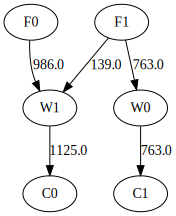

In [24]:
def segment_graph(wrapper):
    dot = Digraph()
    network = wrapper.network
    
    def draw_edge(s, d):
        if wrapper.optimized_value(s, d) > 0:
            dot.edge(s, d, str(wrapper.optimized_value(s, d)))
    
    for f, w in itertools.product(network.factories, network.warehouses):
        draw_edge(f, w)           
    for w, c in itertools.product(network.warehouses, network.customers):
        draw_edge(w, c)
    return dot
segment_graph(segment_wrapper)

### Homework: Summarizing Factory Profitability 

How would we summarize the profitability of a given factory? Cost information is at the factories, but  price/revenue information is "stuck" at the customers. Additionally, at each warehouse, we only have the information about incoming/outgoing flows. 

We'll leave this as an exercise. Think you know the solution? Does your solution generalize to allowing any number of warehouse stops between the factory and the customer? You can email your solution to todd@moka.nyc